---
**License**

 spatial_correlations

 Thu Jul 27 16:30:00 2023\
 Copyright  2023\
 Maria Vitoria Lazarin <mvitoria.lazarin@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 spatial_correlations\
 Copyright (C) 2023 Maria Vitoria Lazarin <mvitoria.lazarin@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Theory




The correlation function describes the distribution of galaxies in the universe. It's a function of one variable (distance) and describes the joint probability, with respect to the Poisson distribution, of finding two galaxies separated by that distance. 

The functions $\xi_{l}^{(n)}$ are defined by (MATSUBARA, 2004)

$$\xi_{l}^{(n)}(x) = \frac{(-1)^{n+l}}{x^{2n-l}} \int \frac{k^2dk}{2 \pi^2} \frac{j_l (kx)}{k^{2n-l}} P(k).$$

For a monopole, $n=l=0$, so 

$$ \xi(r,z) = \sigma^2(r,z) = \frac{1}{2 \pi^2} \int_{0}^{\infty} k^2 P(k,z) j_0 (kr) dk$$

where $P(k,z)$ is the power spectrum at mode $k$ and redshift $z$ and $j_0(kr) = \frac{sen(kr)}{kr}$ is the order zero spherical bessel function.

The equation above computes de 3d spatial correlation function $\xi(r,z)$ from the filtered power spectrum, which we can define as the fourier transform of $\xi(r,z)$. We can filter the power spectrum by multiplying $P(k,z)$ by a window function that takes value 1 in a given region and converges to 0 outside it (in our case, that is $j_0(kr)$). We do that in order to take only the points inside the survey that are correlated with points that are also inside the survey, not with points outside it. 

In [1]:
1  # NumCosmo
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftshift, ifftshift
#import nfft
#from nfft import nfft_adjoint

%matplotlib inline
import random

In [2]:
__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

# running NumCosmo

In [3]:
Omega_c = 0.262 # dark matter energy density
Omega_b = 0.049 # baryonic matter energy density
Omega_k = 0.0 # curvature energy density of the universe
H0 = 67.66 # Hubble constant
Tcmb0 = 2.7255 # CMB temperature
A_s = 2.1e-9 
sigma8 = 0.8277 
n_s = 0.96 
Neff = 0.0 # number of neutrino degrees of freedom
w0 = -1.0 # dark energy equation of state constant (relationship between pressure and energy density)

cosmo = Nc.HICosmoDEXcdm() # cosmological model (similar to Λcdm but with w varying)
# assumes a homogeneus and isotropic universe
cosmo.omega_x2omega_k() 
cosmo.param_set_by_name("H0", H0)
cosmo.param_set_by_name("Omegac", Omega_c)
cosmo.param_set_by_name("Omegab", Omega_b)

reion = Nc.HIReionCamb.new() # implements the reionization using CAMB
prim = Nc.HIPrimPowerLaw.new() # implements the primordial spectrum using a power law

prim.param_set_by_name("n_SA", 0.9658)
prim.param_set_by_name("ln10e10ASA", 3.0904)

reion.param_set_by_name("z_re", 7.0) # redshift at reionization

cosmo.add_submodel(reion) # adds the reionization part to the cosmological model established
cosmo.add_submodel(prim) # calculates the primordial spectrum

In [4]:
use_EH = False 
use_nonlin = True

if use_EH: 
    tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")
    psml = Nc.PowspecMLTransfer.new(tf)
else:
    psml = Nc.PowspecMLCBE.new() # class to implement matter linear power spectrum using CLASS

if use_nonlin:
    zmaxnl = 10.0 # maximum redshift for the halofit correction
    psmnl = Nc.PowspecMNLHaloFit.new(psml, zmaxnl, 1.0e-5) # nonlinear matter power spectrum from Halofit model
    # 1.0e-5 is the relative tolerance (precision) for halofit computations
    ps = psmnl 
else:
    ps = psml

kmin = 1.0e-6
kmax = 1.0e3

# New linear matter power spectrum object based of the EH transfer function.
ps.require_kmin(kmin)
ps.require_kmax(kmax)

ps_corr3d = Ncm.PowspecCorr3d.new(ps) 
# Creates a new NcmPowspecCorr3d from the power spectrum ps.
ps_corr3d.set_best_lnr0() 
# Sets the value of ln(r_0) which giver the best results for the transformation based on the current value of ln(k_0).

In [5]:
psml.prepare(cosmo)

ps_corr3d.prepare(cosmo)
# prepares the object by applying the filter to the power spectrum

<Figure size 640x480 with 0 Axes>

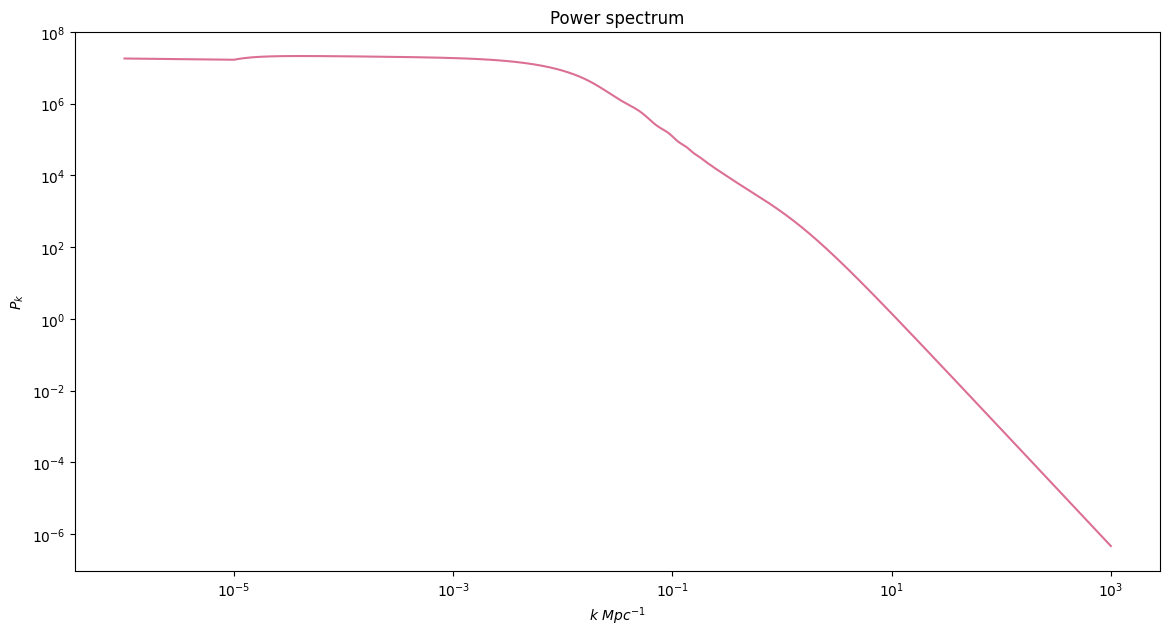

In [6]:
plt.figure()
fig, axs = plt.subplots(1, figsize=(14, 7))

k = np.geomspace (kmin, kmax, 1000)
Pk = [k_i**(-1) * ps.eval(cosmo, 0.0, k_i) for k_i in k]
# Parâmetros de P(k,z) = model, z, k. Avalia o espectro de potência em z e k.
# k é o modo. Avalia a partir do modelo definido. (k seria como a frequência na FFT) 


axs.plot(k, Pk, 'palevioletred')

axs.set_xscale("log")
axs.set_yscale("log")
axs.set_ylabel(r"$P_k$")
axs.set_xlabel(r"$k$ $Mpc^{-1}$")

plt.title("Power spectrum")
plt.show()


<Figure size 640x480 with 0 Axes>

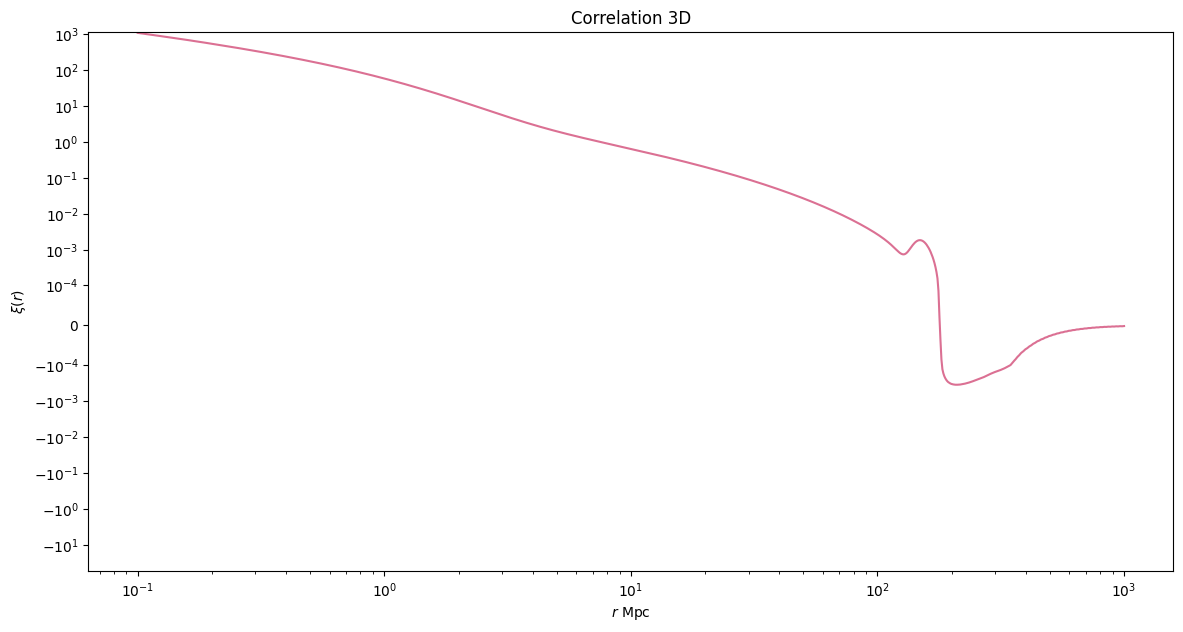

In [7]:
plt.figure()
fig, axs = plt.subplots(1, figsize=(14, 7))

# Plot settings

r = np.geomspace(1.0e-1, 1.0e3, 1000)
xi = [ps_corr3d.eval_xi(0.0, r_i) for r_i in r]

axs.plot(r, xi, 'palevioletred')

axs.set_xscale("log")
axs.set_yscale("symlog", linthresh=1.0e-4)
axs.set_ylabel(r"$\xi(r)$")
axs.set_xlabel(r"$r$ Mpc")

plt.title("Correlation 3D")
plt.show()

_______________________________________________________________________________________________________________________________________________

# FFT code

- Performing the analytical calculation of the function that will enter the FFT argument

$$ \begin{align} \xi(r,z) & = \sigma^2(r,z) = \frac{1}{2 \pi^2} \int_{0}^{\infty} k^2 P(k,z) j_0 (kr) dk \\
& = \frac{1}{2 \pi^2} \int_{0}^{\infty} k^2 P(k,z) \frac{\sin(kr)}{kr} dk \\
& = \frac{1}{2 \pi^2} \int_{0}^{\infty} \frac{k}{r}P(k,z) \sin(kr) dk \\
& = \frac{1}{2 \pi^2} \int_{0}^{\infty} \frac{k}{r}P(k,z) \left(\frac{e^{ikr}-e^{-ikr}}{2i}\right) dk \\
& = \frac{1}{2 \pi^2} \int_{0}^{\infty} \frac{k}{r}P(k,z)\left(\frac{e^{ikr}-e^{-ikr}}{2e^{i\pi/2}}\right)dk \\
& = \frac{1}{2 \pi^2} \int_{0}^{\infty} \frac{k}{2r}P(k,z)(e^{ikr}-e^{-ikr})e^{-i\pi/2}dk \\
& = \frac{1}{4r \pi^2} \left(\int_{0}^{\infty} k P(k,z)e^{ikr}e^{-i\pi/2}dk -  \int_{0}^{\infty} k P(k,z)e^{-ikr}e^{-i\pi/2}dk\right)\\
\end{align}$$

We'll call -k = k'. Changing the variable in the second integral and the limits of integration,

$$ \begin{align} 
& = \frac{1}{4r \pi^2} \left(\int_{0}^{\infty} k P(k,z)e^{ikr}e^{-i\pi/2}dk -  \int_{0}^{-\infty} (-k') P(-k',z)e^{ik'r}e^{-i\pi/2}(-dk')\right)\\
& = \frac{1}{4r \pi^2} \left(\int_{0}^{\infty} k P(k,z)e^{ikr}e^{-i\pi/2}dk - \int_{0}^{-\infty} (k') P(-k',z)e^{ik'r}e^{-i\pi/2}(dk')\right)\\
\end{align}$$

Inverting the integral

$$ \begin{align} 
& = \frac{1}{4r \pi^2} \left(\int_{0}^{\infty} k P(k,z)e^{ikr}e^{-i\pi/2}dk + \int_{-\infty}^{0} (k') P(-k',z)e^{ik'r}e^{-i\pi/2}(dk')\right)\\
& = \frac{1}{4r \pi^2} \left(\int_{-\infty}^{\infty} k P(|k|,z)e^{ikr}e^{-i\pi/2}dk \right)
\end{align}$$

So

$$ \xi(r,z) = \frac{1}{2\pi} \left(\int_{-\infty}^{\infty} \frac{1}{2\pi r}k P(|k|,z)e^{-i\pi/2} e^{ikr}dk \right)$$

Keeping the above equation in mind, let's compare it to the format of a generalized Fourier transform:

$$ \hat{f}(\omega) = \int_{-\infty}^{\infty} f(x) e^{-i \omega x} dx$$
$$ f(x) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} \hat{f}(\omega) e^{i\omega x} d \omega$$

Since we are dealing with a positive power in the exponential, we will calculate the ifft instead of the fft. Thus, the function that will be inserted as an argument of the FFT will be $f = \frac{1}{2\pi r}k P(k,z) e^{-i\pi/2}$. 

/tmp/ipykernel_6514/1566716996.py:11: RuntimeWarning: divide by zero encountered in divide
  xi_ft = fftshift(fft(f, NFFT)) * 1J * kmax / (dist*fs*2*np.pi**2*(-1)**np.arange(-NFFT/2, NFFT/2))
/tmp/ipykernel_6514/1566716996.py:11: RuntimeWarning: invalid value encountered in divide
  xi_ft = fftshift(fft(f, NFFT)) * 1J * kmax / (dist*fs*2*np.pi**2*(-1)**np.arange(-NFFT/2, NFFT/2))


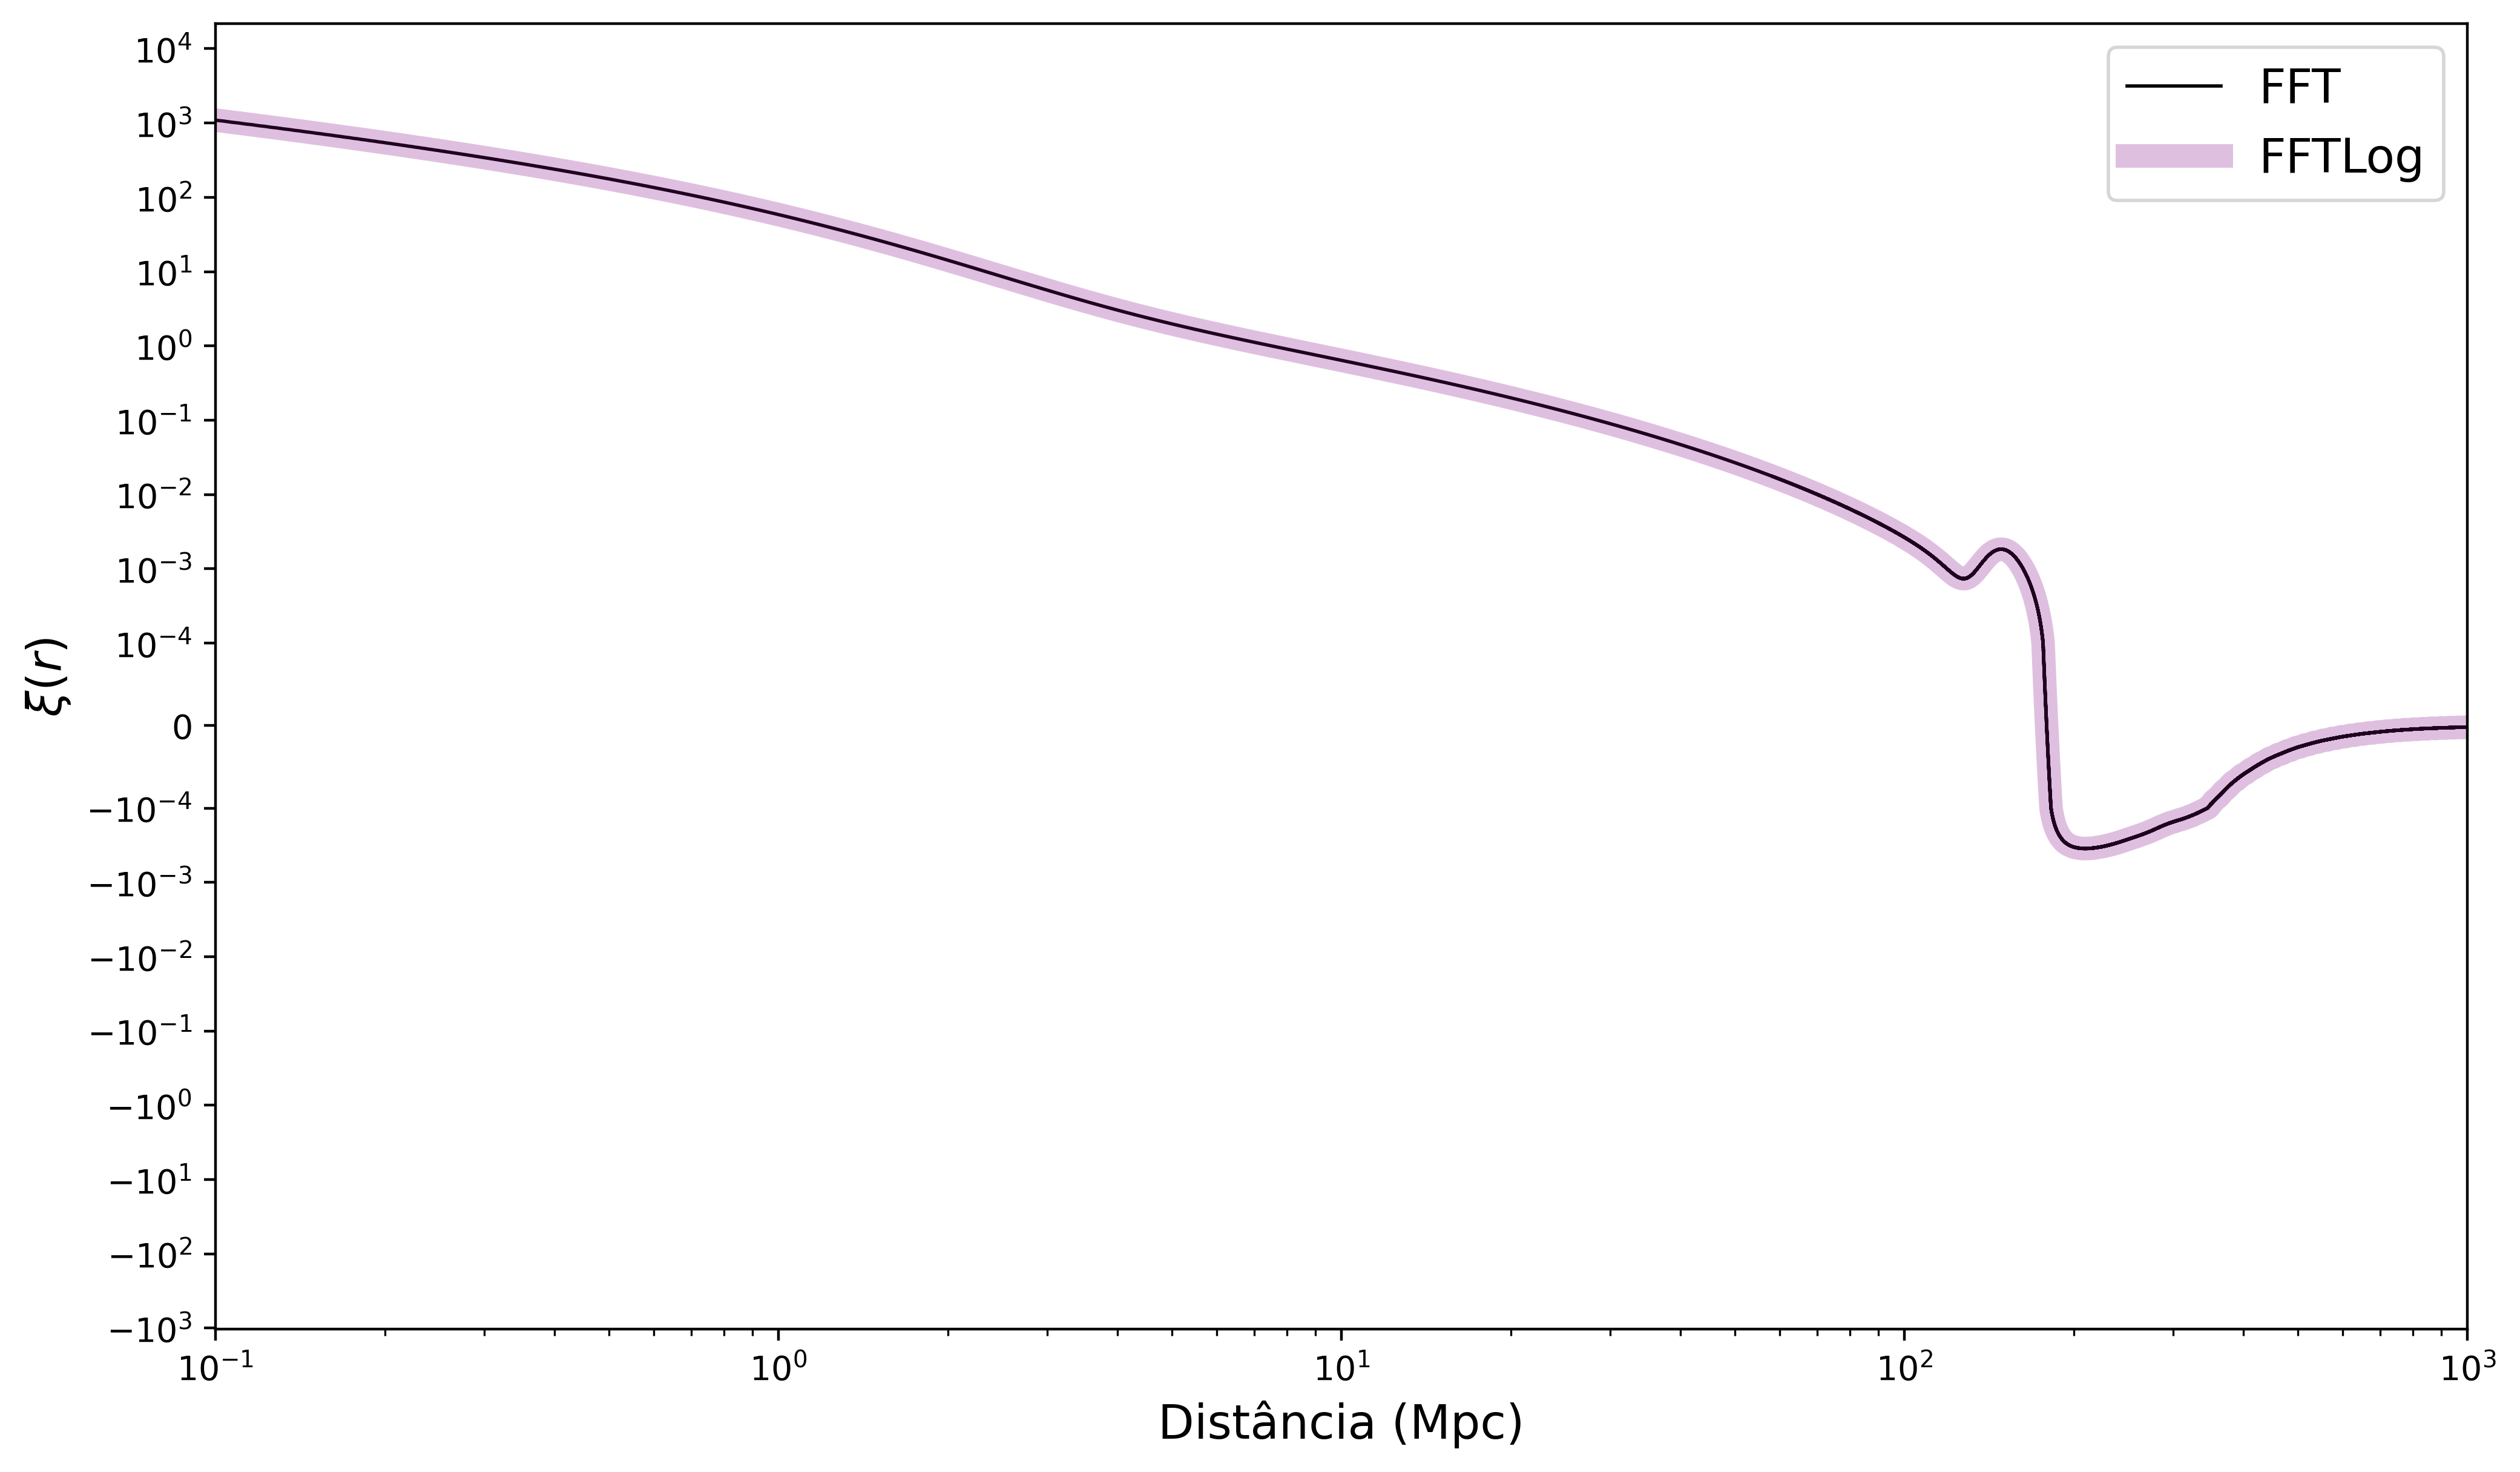

In [33]:
fs = 1000000
kmax = 1.0e3
k = np.linspace(-kmax, kmax, fs, endpoint=False)

NFFT = fs
dist = (2.0*np.pi/(2.0 * kmax)) * np.arange(-NFFT/2, NFFT/2)
# por que tem um kmax?
xi = [ps_corr3d.eval_xi(0.0, r_i) for r_i in dist]

Pk = np.array([ps.eval(cosmo, 0.0, np.abs(k_i)+1.0e-100) for k_i in k])
f = k * Pk
xi_ft = fftshift(fft(f, NFFT)) * 1J * kmax / (dist*fs*2*np.pi**2*(-1)**np.arange(-NFFT/2, NFFT/2))

# por que tem um kmax multiplicando? Pq tem um fs dividindo? Pq o pi tá ao quadrado? pq tem um -1^np.arange()?

fig, axs = plt.subplots(1, figsize=(12, 7), dpi = 400)

axs.plot(dist, np.real(xi_ft), color = "black", linewidth = 1, linestyle = "-", label = "FFT")
# axs.plot(dist, np.imag(xi_ft), 'g')
# axs.plot(dist, np.abs(xi_ft), 'r')
axs.plot(dist, xi, color = "purple", linewidth = 7, alpha = 0.25, label = "FFTLog")

axs.set_xscale("log")
axs.set_yscale("symlog", linthresh=1.0e-4)
axs.set_ylabel(r"$\xi(r)$", fontsize=14)
axs.set_xlabel(r"Distância (Mpc)", fontsize=14)
axs.set_xlim(1e-1, 1e3)
axs.legend(fontsize=14)
#axs[1].set_ylim(axs[0].get_ylim)
# axs[1].set_yticks([])
# plt.ylim(-10e-2, 10e3)

In [9]:
dif = []

for i in range(len(dist)):
    dif.append(abs(xi[i]- np.real(xi_ft[i]))/abs(xi[i]))

(0.1, 1000.0)

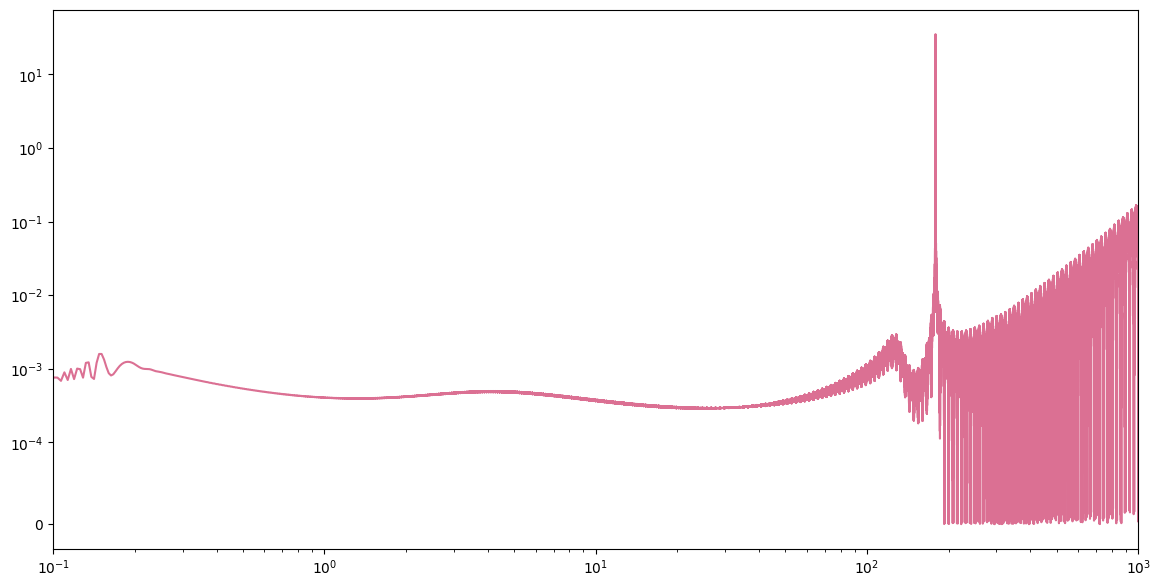

In [10]:
fig, axs = plt.subplots(1, figsize=(14, 7))
axs.plot(dist, dif, 'palevioletred')
plt.yscale("symlog", linthresh=1.0e-4)
plt.xscale("log")
plt.xlim(1e-1, 1e3)

In [11]:
np.linspace(-1,1,10,startpoint=False,endpoint=False)

TypeError: linspace() got an unexpected keyword argument 'startpoint'

In [ ]:
len(k)

1999999

In [ ]:
k[fs]

0.001

array([0.00000000e+00, 3.14159422e-03, 6.28318845e-03, ...,
       3.14158480e+03, 3.14158794e+03, 3.14159108e+03])

In [ ]:
np.arange(-2,2)

array([-2, -1,  0,  1])